# Lrp loss  - Eperiment 1

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from python.model_keras import initialize_brats_model
from python.train.train_lrp_loss import train, get_lrp_loss, threshold_to_one, analysis_to_segmentation, soft_dice_loss
from python.mask_utils import mask_value, get_mask_stat, get_mask_of_seg_rgb, get_mask_of_brain, get_mask_of_seg
from python.data_utils import LggHggGenerator
from python.visualization import plot_rgb, plot_gray, plot_lrp
from python import plots

In [2]:
from tensorflow import keras
import innvestigate
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
import innvestigate

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Data loading

In [4]:
batch_size = 32
epochs = 5
IMG_HEIGHT = 240
IMG_WIDTH = 240

In [5]:
train_dir = '../data/train/confidence_19/'
seg_train_dir = '../data/train/seg_confidence_19/'
val_dir = '../data/valid/confidence_19/'
seg_val_dir = '../data/valid/seg_confidence_19/'
test_dir = '../data/test/confidence_19/'
seg_test_dir = '../data/test/seg_confidence_19/'

train_image_generator = ImageDataGenerator(rescale=1./255, 
                                           rotation_range=45,
                                           horizontal_flip=True,
                                           vertical_flip=True)
train_seg_generator = ImageDataGenerator(rotation_range=45,
                                           horizontal_flip=True,
                                           vertical_flip=True)
val_image_generator = ImageDataGenerator(rescale=1./255)
val_seg_generator = ImageDataGenerator()

lgg_hgg_generator = LggHggGenerator(train_image_generator, train_seg_generator, train_dir, seg_train_dir)
val_lgg_hgg_generator = LggHggGenerator(val_image_generator, val_seg_generator, val_dir, seg_val_dir)
test_lgg_hgg_generator = LggHggGenerator(val_image_generator, val_seg_generator, test_dir, seg_test_dir)

In [6]:
train_image_gen = lgg_hgg_generator.get_image_generator(batch_size, True)
train_seg_gen = lgg_hgg_generator.get_seg_generator(batch_size, True)
val_image_gen = val_lgg_hgg_generator.get_image_generator(batch_size)
val_seg_gen = val_lgg_hgg_generator.get_seg_generator(batch_size)
test_image_gen = test_lgg_hgg_generator.get_image_generator(batch_size, True)
test_seg_gen = test_lgg_hgg_generator.get_seg_generator(batch_size, True)

Found 1645 images belonging to 2 classes.
Found 1645 images belonging to 2 classes.
Found 446 images belonging to 2 classes.
Found 446 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


### Visualization

In [7]:
x, y = next(val_image_gen)
x_seg, y_seg = next(val_seg_gen)

(32, 240, 240, 3)


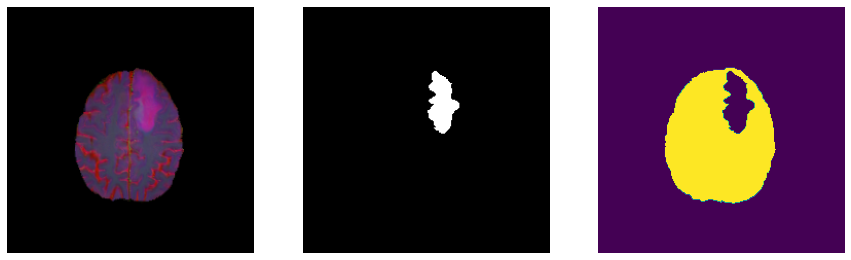

In [8]:
print(x.shape)
i = 11
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()
plot_rgb(x[i], ax= axes[0])
plot_gray(threshold_to_one(x_seg[i]), ax= axes[1])
plot_rgb(get_mask_of_brain(x[i], get_mask_of_seg(x_seg[i]).squeeze()), ax= axes[2])

## Model definition

In [7]:
model = initialize_brats_model(IMG_HEIGHT, IMG_WIDTH)
optimizer = keras.optimizers.Adam()
analyzer = innvestigate.create_analyzer("lrp.epsilon", model, epsilon=1)
loss_function = get_lrp_loss(analyzer)

## Model training

In [8]:
train(model, 
      train_image_gen, 
      train_seg_gen, 
      val_image_gen, 
      val_seg_gen,
      loss_function,
      optimizer,
      epochs, 
      batch_size)

1.2642593e-10
4.265252e-08
1.5241547e-09
1.2721425e-09
6.310972e-10
2.9707203e-10
1.4457709e-10
2.7421646e-10
2.4896488e-10
3.8102496e-10
6.122803e-10
6.5372046e-09
3.5227718e-08
2.0334962e-08
3.7491205e-08
2.6984901e-08
3.00025e-08
7.1653283e-09
1.8645514e-08
5.1727547e-08
6.045378e-08
6.607026e-08
8.90776e-08
9.338251e-08
7.974441e-08
5.8469936e-08
2.6292762e-08
2.525049e-08
2.3727049e-08
8.2688416e-08
2.6045592e-07
1.6448165e-07
2.3229178e-07
4.3173497e-07
1.6843413e-07
1.2845527e-07
7.8785924e-08
2.7634388e-07
2.2672366e-07
1.9731664e-07
9.991731e-08
3.5521958e-07
1.8307459e-07
6.0085887e-07
5.0210303e-07
2.8732006e-07
6.933913e-08
3.6777983e-08
1.7057118e-08
7.4115203e-09
9.263349e-09
6.2871424e-09
1.4189896e-08
4.174782e-09
2.2716353e-09
1.6123144e-09
2.6733087e-09
3.9197103e-09
1.7584572e-09
1.0060209e-09
3.4023986e-09
2.8159954e-09
7.758081e-09
3.5887426e-09
1.19398615e-08
4.8691033e-09
Epoch: 0, Train loss: 3.891, Train mask: 0.450, Train accuracy: 0.623, Test loss: 1.973, Tes

In [12]:
model.save('../models/brats19_12.h5')

## Evaluation

### Testing models and data

In [31]:
images, y = next(test_image_gen)
images_seg, y_seg = next(test_seg_gen)

In [7]:
model = load_model('../models/brats19_3.h5')
model2 = load_model('../models/brats19_10.h5')
model3 = load_model('../models/brats19_8.h5')
model4 = load_model('../models/brats19_11.h5')
models = [model, model2, model3, model4]
analyzers = [innvestigate.create_analyzer("lrp.epsilon", m, epsilon=1) for m in models]

### Some helper functions

In [15]:
def postprocess_lrp(analyzed_image):
    analyzed_image = analyzed_image.sum(axis=np.argmax(np.asarray(analyzed_image.shape) == 3))
    analyzed_image /= np.max(np.abs(analyzed_image))
    return analyzed_image

In [58]:
def show_analysis(image, seg, y, model, analyzer):
    a = analyzer.analyze([image])['input_layer'][0]
    pred = model.predict(np.array([image])).argmax(axis=1)[0]
    mask_v = mask_value(a, image, get_mask_of_seg_rgb(seg))
    print("Mask Value: ", mask_v)
    print("Label: ", int(y), "Pred: ", pred)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes = axes.flatten()
    plot_lrp(postprocess_lrp(a), ax=axes[0], title = "{:.3f}".format(mask_v))
    plot_rgb(image, ax=axes[1])
    plot_gray(seg, ax=axes[2])

In [73]:
indx = 10
def show_analysis_all_models(image, seg, y, models, analyzers, labels = ["LGG", "HGG"]):
    fig, axes = plt.subplots(1, 6, figsize=(18, 3))
    axes = axes.flatten()
    plot_rgb(image, ax=axes[0], title = "label: {}".format(labels[int(y)]))
    plot_gray(seg, ax=axes[1])
    for i in range(4):
        a = analyzers[i].analyze([image])['input_layer'][0]
        pred = models[i].predict(np.array([image])).argmax(axis=1)[0]
        mask_v = mask_value(a, image, get_mask_of_seg_rgb(seg))
        plot_lrp(postprocess_lrp(a), ax=axes[i + 2], title = "{:.3f}, {}".format(mask_v, labels[pred]))

### Visualize predictions of all models

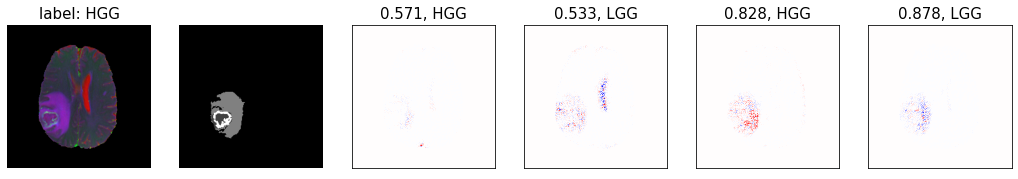

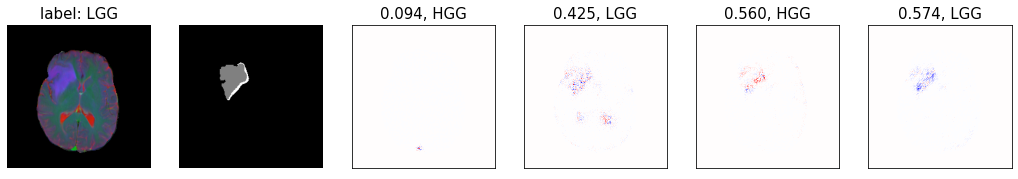

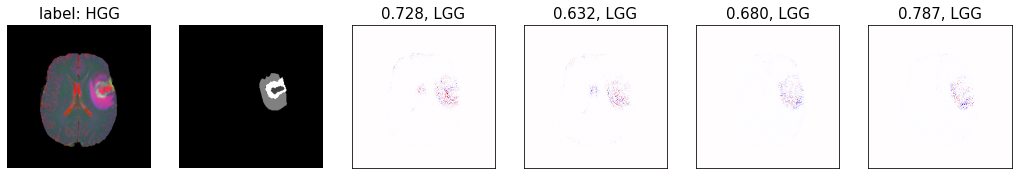

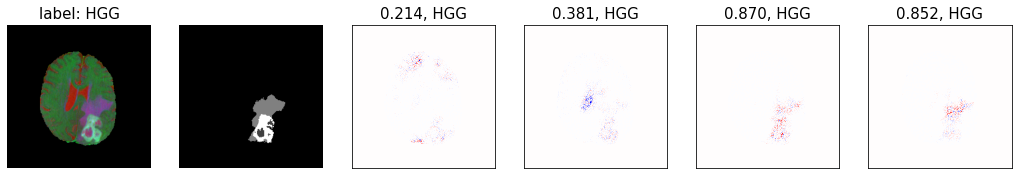

In [86]:
for indx in [5,7,12,18]:
    show_analysis_all_models(images[indx], images_seg[indx], y[indx], models, analyzers)
    plt.show()

### Visualize one prediction for all models

Mask Value:  0.45359626
Label:  1 Pred:  1


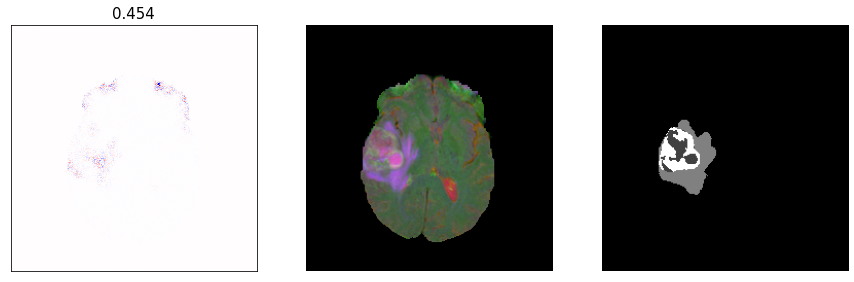

Mask Value:  0.7938044
Label:  1 Pred:  1


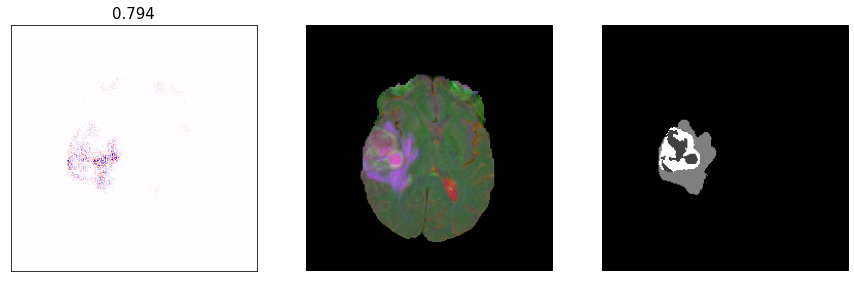

Mask Value:  0.8672323
Label:  1 Pred:  1


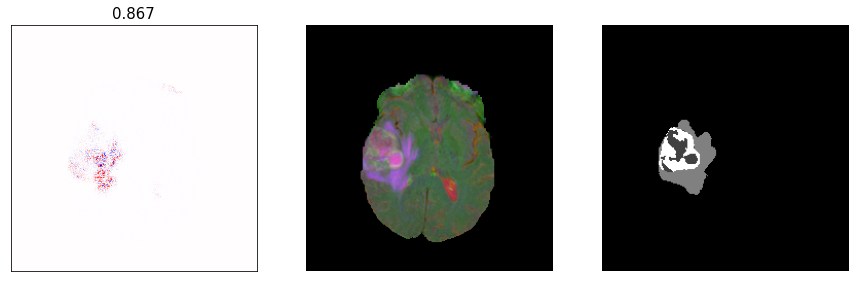

Mask Value:  0.9336631
Label:  1 Pred:  1


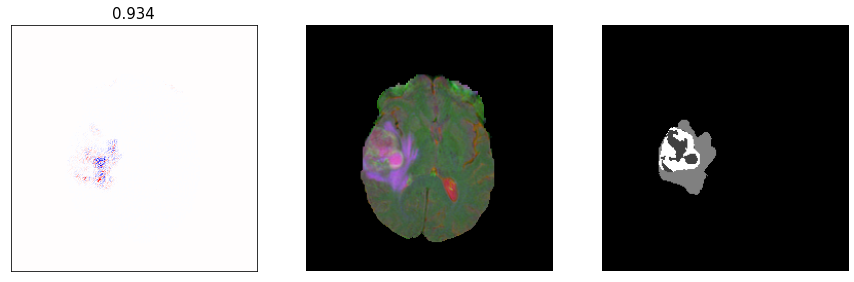

In [60]:
indx = 10
m_num = 3
for i in range(4):
    show_analysis(images[indx], images_seg[indx], y[indx], models[i], analyzers[i])
    plt.show()

### Visualize performance of models

Found 246 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
LGG:  0.26938382 HGG: 0.1517538
Model performance:
              precision    recall  f1-score   support

         LGG       0.76      0.54      0.63       116
         HGG       0.67      0.85      0.75       130

    accuracy                           0.70       246
   macro avg       0.72      0.69      0.69       246
weighted avg       0.71      0.70      0.70       246



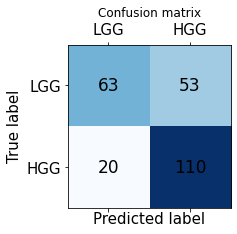

In [9]:
evaluate_model(model, test_lgg_hgg_generator.get_image_generator(batch_size), test_lgg_hgg_generator.get_seg_generator(batch_size))

Found 246 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
LGG:  0.36763915 HGG: 0.36675805
Model performance:
              precision    recall  f1-score   support

         LGG       0.74      0.87      0.80       116
         HGG       0.86      0.72      0.79       130

    accuracy                           0.79       246
   macro avg       0.80      0.80      0.79       246
weighted avg       0.80      0.79      0.79       246



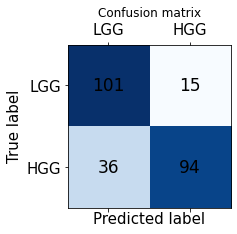

In [10]:
evaluate_model(model2, test_lgg_hgg_generator.get_image_generator(batch_size), test_lgg_hgg_generator.get_seg_generator(batch_size))

Found 246 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
LGG:  0.48712617 HGG: 0.6267527
Model performance:
              precision    recall  f1-score   support

         LGG       0.85      0.49      0.62       116
         HGG       0.67      0.92      0.78       130

    accuracy                           0.72       246
   macro avg       0.76      0.71      0.70       246
weighted avg       0.76      0.72      0.70       246



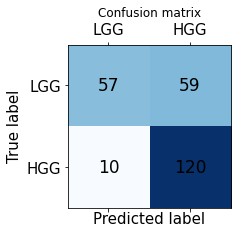

In [11]:
evaluate_model(model3, test_lgg_hgg_generator.get_image_generator(batch_size), test_lgg_hgg_generator.get_seg_generator(batch_size))

Found 246 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
LGG:  0.48840004 HGG: 0.6651576
Model performance:
              precision    recall  f1-score   support

         LGG       0.69      0.83      0.75       116
         HGG       0.81      0.66      0.73       130

    accuracy                           0.74       246
   macro avg       0.75      0.74      0.74       246
weighted avg       0.75      0.74      0.74       246



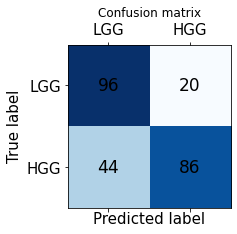

In [12]:
evaluate_model(model4, test_lgg_hgg_generator.get_image_generator(batch_size), test_lgg_hgg_generator.get_seg_generator(batch_size))

In [8]:
def evaluate_model(model, val_image_gen, val_seg_gen):
    m, p, y = get_mask_stat(val_image_gen, val_seg_gen, model)
    print("LGG: ", np.mean(m[y==0]), "HGG:", np.mean(m[y==1]))
    
    y_true_v = []
    pred_v = []
    iterations = val_image_gen.samples / batch_size
    for i, (images, labels) in enumerate(val_image_gen):
        prob = model.predict(images)
        p = prob.argmax(axis=1)
        pred_v.extend(p)
        y_true_v.extend(labels)
        if i + 1 > iterations:
            break
    plots.plot_model_performance(y_true_v, pred_v)

In [1]:
!pip install --use-feature=2020-resolver "git+https://github.com/albermax/innvestigate.git@updates_towards_tf2.0"

  Cloning https://github.com/albermax/innvestigate.git (to revision updates_towards_tf2.0) to /tmp/pip-req-build-bgpq32jx
     |████████████████████████████████| 829 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 421.8 MB 58 kB/s s eta 0:00:01
     |████████████████████████████████| 50 kB 6.0 MB/s  eta 0:00:01
     |████████████████████████████████| 3.8 MB 9.5 MB/s eta 0:00:01


     |████████████████████████████████| 448 kB 16.0 MB/s eta 0:00:01
  Created wheel for innvestigate: filename=innvestigate-2.0.0-py3-none-any.whl size=107093 sha256=dfa2f293613f502dd7f30132a2f41d9d751a9aac7352e6b423d5764ccaf90b58
  Stored in directory: /tmp/pip-ephem-wheel-cache-24o9h0hb/wheels/5c/25/10/76772cf76d6eb4346d31e1f6e32bce55ee94d9e7c6c98d1a3f
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=493275 sha256=84af21db6f2deb1ae6c2e1edac1b1fdf82999276bad6bcb002069b9eb47c7a29
  Stored in directory: /root/.cache/pip/wheels/6e/9c/ed/4499c9865ac1002697793e0ae05ba6be33553d098f3347fb94
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7635 sha256=453f923fd1b573aeb26800b42fcb488af2aa127f403831b0f20f979029419236
  Stored in directory: /root/.cache/pip/wheels/19/a7/b9/0740c7a3a7d1d348f04823339274b90de25fbcd217b2ee1fbe
Successfully built innvestigate future gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflo